In [2]:
!pip install --pre deepchem

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 24.2 MB/s eta 0:00:00


In [3]:
import deepchem as dc

Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


In [4]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

In [5]:
import numpy as np
import matplotlib.pyplot as plt

In [6]:
tasks, datasets, transformers = dc.molnet.load_bace_regression(featurizer='ecfp', splitter='random')
train_dataset, valid_dataset, test_dataset = datasets

[20:03:40] DEPRECATION WARNING: please use MorganGenerator
[20:03:40] DEPRECATION WARNING: please use MorganGenerator
[20:03:40] DEPRECATION WARNING: please use MorganGenerator
[20:03:40] DEPRECATION WARNING: please use MorganGenerator
[20:03:40] DEPRECATION WARNING: please use MorganGenerator
[20:03:40] DEPRECATION WARNING: please use MorganGenerator
[20:03:40] DEPRECATION WARNING: please use MorganGenerator
[20:03:40] DEPRECATION WARNING: please use MorganGenerator
[20:03:40] DEPRECATION WARNING: please use MorganGenerator
[20:03:40] DEPRECATION WARNING: please use MorganGenerator
[20:03:40] DEPRECATION WARNING: please use MorganGenerator
[20:03:40] DEPRECATION WARNING: please use MorganGenerator
[20:03:40] DEPRECATION WARNING: please use MorganGenerator
[20:03:40] DEPRECATION WARNING: please use MorganGenerator
[20:03:40] DEPRECATION WARNING: please use MorganGenerator
[20:03:40] DEPRECATION WARNING: please use MorganGenerator
[20:03:40] DEPRECATION WARNING: please use MorganGenerat

In [7]:
print(f"The tasks are {tasks}")
print(f"The transformers are {transformers}")
print("The transformer normalizes the outputs' y values: {}".format(transformers[0].transform_y))

The tasks are ['pIC50']
The transformers are [<deepchem.trans.transformers.NormalizationTransformer object at 0x79f5c1f0f4f0>]
The transformer normalizes the outputs' y values: True


In [8]:
print(train_dataset)
print(valid_dataset)
print(test_dataset)

<DiskDataset X.shape: (1210, 1024), y.shape: (1210, 1), w.shape: (1210, 1), task_names: ['pIC50']>
<DiskDataset X.shape: (151, 1024), y.shape: (151, 1), w.shape: (151, 1), ids: ['O=C1N(CCC1)c1cc(ccc1)C(=O)NC(Cc1ccccc1)C(O)C[NH2+]C(C(=O)NC1CCCCC1)C'
 'S1(=O)(=O)N(CCCC1)c1cc(cc(NCC)c1)C(=O)N[C@H]([C@H](O)C[NH2+]C(C)(C)c1cc(ccc1)C(F)(F)F)Cc1ccccc1'
 'O1CC(NC(=O)c2cc(cc(c2)C(=O)NCC\\C=C\\C1)C)C(O)C[NH2+]Cc1cc(ccc1)C(C)C'
 ... 'O1c2c(cc(cc2)-c2cc(OCC)ccc2)C2(N=C(N)N(C)C2=O)CC1(C)C'
 'O(CCC)c1cc(ccc1)-c1cc(ccc1)C1CC1C1(N=C(N)N(C)C(=O)C1)C'
 'O=C1N(C)C(=NC(C1)(C)C1CC1c1cc(ccc1)CCc1ccccc1)N'], task_names: ['pIC50']>
<DiskDataset X.shape: (152, 1024), y.shape: (152, 1), w.shape: (152, 1), ids: ['Fc1cc(cc(F)c1)CC(NC(=O)C(N1CCC(CCCC)C1=O)CCc1ccccc1)C(O)C1[NH2+]Cc2c(C1)cccc2'
 'Brc1cc2c(SCC[C@@H]2OC(=O)[C@@H]2[NH2+]C[C@]3(C2)c2c(NC3=O)cccc2)cc1'
 'O(C)c1cc(ccc1)-c1cc(ccc1)C1(N=C(C)C(=N1)N)C' ...
 'O(C)c1ccc(cc1C)C1(N=C(C)C(=N1)N)c1cc(ccc1)-c1cncnc1'
 'Fc1cc(cc(F)c1)CC(NC(=O)C)C(O)C[NH2+]C1(CCCCC1)

In [9]:
#these are already tuned
output_variance = 7.908735015054668
length_scale = 6.452349252677817
noise_level = 0.10475507755839343
kernel = output_variance**2 * RBF(length_scale=length_scale, length_scale_bounds='fixed') + WhiteKernel(noise_level=noise_level, noise_level_bounds='fixed')
alpha = 4.989499481123432e-09

In [10]:
sklearn_gpr = GaussianProcessRegressor(kernel=kernel, alpha=alpha)
model = dc.models.SklearnModel(sklearn_gpr)

In [11]:
model.fit(train_dataset)

In [12]:
metric1 = dc.metrics.Metric(dc.metrics.mean_squared_error)
metric2 = dc.metrics.Metric(dc.metrics.r2_score)

In [13]:
print("Training set score: {}".format(model.evaluate(train_dataset, [metric1, metric2])))
print("Test set score: {}".format(model.evaluate(test_dataset, [metric1, metric2])))

Training set score: {'mean_squared_error': 0.04667705116847313, 'r2_score': 0.9533229488315269}
Test set score: {'mean_squared_error': 0.28695099300416327, 'r2_score': 0.7594265994536754}


In [14]:
def predict_with_error(dc_model, X, y_transformer):
  samples = model.model.sample_y(X, 100)
  means = y_transformer.untransform(np.mean(samples, axis=1))
  stds = y_transformer.y_stds[0] * np.std(samples, axis=1)

  return means, stds

In [56]:
y_meas_train = transformers[0].untransform(train_dataset.y)
y_pred_train, y_pred_train_stds = predict_with_error(model, train_dataset.X, transformers[0])
print(y_meas_train)
print(np.ravel(y_meas_train)) #lgtm

[[6.124939 ]
 [7.6300001]
 [6.6197886]
 ...
 [5.3767509]
 [7.251812 ]
 [4.       ]]
[6.124939  7.6300001 6.6197886 ... 5.3767509 7.251812  4.       ]


In [57]:
#Rage against the dying of the light

(2.5, 10.5)

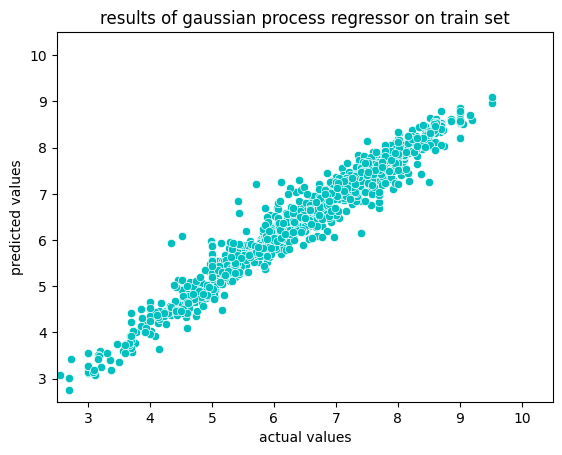

In [62]:
import seaborn as sns
ax = sns.scatterplot(x=np.ravel(y_meas_train), y=np.ravel(y_pred_train), color="c")
ax.set_title("results of gaussian process regressor on train set")
ax.set_ylabel("predicted values")
ax.set_xlabel("actual values") #not very informative, I know
plt.xlim([2.5, 10.5])
plt.ylim([2.5, 10.5])

(2.5, 10.5)

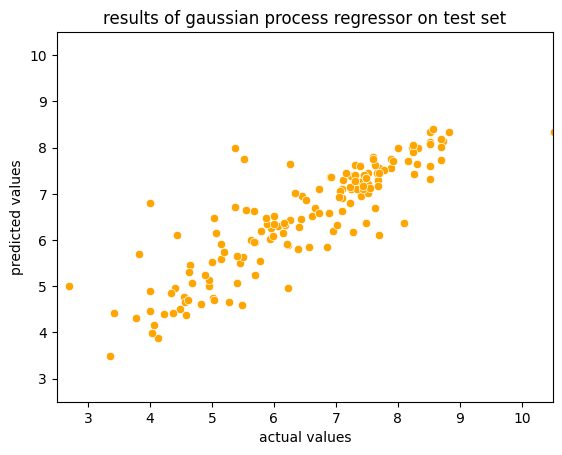

In [64]:
y_meas_test = transformers[0].untransform(test_dataset.y)
y_pred_test, y_pred_test_stds = predict_with_error(model, test_dataset.X, transformers[0])

ax = sns.scatterplot(x=np.ravel(y_meas_test), y=np.ravel(y_pred_test), color="orange")
ax.set_title("results of gaussian process regressor on test set")
ax.set_ylabel("predicted values")
ax.set_xlabel("actual values") #not very informative, I know
plt.xlim([2.5, 10.5])
plt.ylim([2.5, 10.5])

In [65]:
def percent_within_std(y_meas, y_pred, y_std):
  assert len(y_meas) == len(y_pred) and len(y_meas) == len(y_std), 'length of y_meas and y_pred'

  count_within_error = 0
  for i in range(len(y_meas)):
    if abs(y_meas[i][0]-y_pred[i]) < y_std[i]:
      count_within_error += 1

  return count_within_error/len(y_meas)

In [66]:
percent_within_std(y_meas_train, y_pred_train, y_pred_train_stds)

0.9289256198347108

In [67]:
percent_within_std(y_meas_test, y_pred_test, y_pred_test_stds)

0.7828947368421053

<Axes: ylabel='Count'>

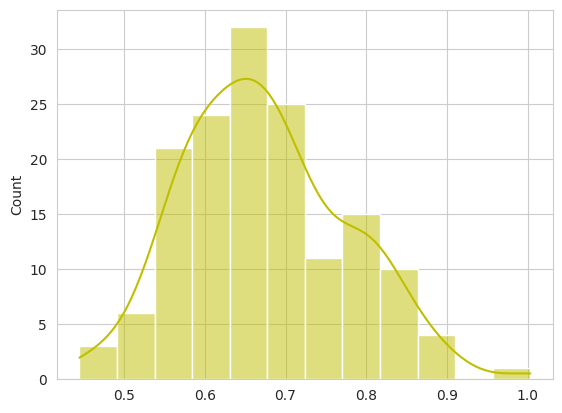

In [93]:
sns.set_style("whitegrid")
sns.histplot(x=y_pred_test_stds, color="y", kde=True) #looks more or less gaussian :)
#I should absolutely figure out how to put different colors on each of the bars
#my problem right now is that seaborn messes up the normal plot when I add a hue because its a percentage% so all the bars become the same height

In [60]:
e